In [ ]:
!pip install scikit-multilearn


In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
from prettytable import PrettyTable
from rich.console import Console
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score, log_loss, accuracy_score


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import string

from skmultilearn.problem_transform import BinaryRelevance
from itertools import cycle


import warnings


In [ ]:
warnings.filterwarnings("ignore")

# Mounting the Dataset

* Uploaded the dataset to Google Drive to avoid constant uploads to Google Colab

In [ ]:
drive.mount('/content/drive')
train_path = '/content/drive/My Drive/project-dataset/train.csv/train.csv'
test_path = '/content/drive/My Drive/project-dataset/test.csv/test.csv'
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Printing the Dataset

* Wanted to visualize the dataset using the pandas head feature to get an idea of what it comprised of

In [ ]:
train_data.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


# Dataset Statistics

* The head function only gave us somewhat of an idea about the data

* Instead of unnecessary scrolling of the Excel file, we decided to use our dear friend Python to give us a few stats about the dataset

* We still ended up scrolling the Excel file to actually verify if the code was giving the correct results lol

In [ ]:
size = train_data.shape[0]

print(f'Number of tweets: {size}')

label_columns = train_data.columns[2:]

for column in label_columns:
    label_counts = train_data[column].value_counts()
    print(f"Column: {column}")
    print(f"Label Statistics:")
    print(label_counts)
    print()

Number of tweets: 159571
Column: toxic
Label Statistics:
0    144277
1     15294
Name: toxic, dtype: int64

Column: severe_toxic
Label Statistics:
0    157976
1      1595
Name: severe_toxic, dtype: int64

Column: obscene
Label Statistics:
0    151122
1      8449
Name: obscene, dtype: int64

Column: threat
Label Statistics:
0    159093
1       478
Name: threat, dtype: int64

Column: insult
Label Statistics:
0    151694
1      7877
Name: insult, dtype: int64

Column: identity_hate
Label Statistics:
0    158166
1      1405
Name: identity_hate, dtype: int64



# Frequency of Labels

* The first 5 lines of the dataset gave us a mini heart attack initially when we printed them out using the head function, this was because all the labels were 0

* It gave us an idea that class imbalance might exist in the dataset so we decided to print out a few graphs and see what was going on inside

* We started of with checking the frequency of each of the 6 labels in the dataset

Text(0, 0.5, 'Number of Comments')

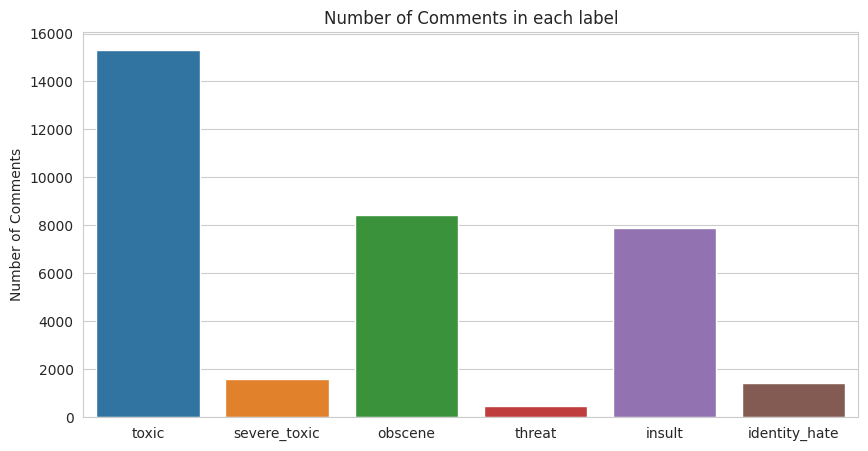

In [ ]:
labels = train_data.columns[2:]
labels_count = train_data[labels].sum()
plt.figure(figsize = (10,5))
sns.barplot(x = labels_count.index,y = labels_count.values)
plt.title("Number of Comments in each label")
plt.ylabel("Number of Comments")

# Realization about Dataset

* This graph made things worse for us when we realized that the frequency of labels was extremely low.

* To graphically see how imbalanced the dataset was, we plotted the graph below seeing how many comments had no labels attached.

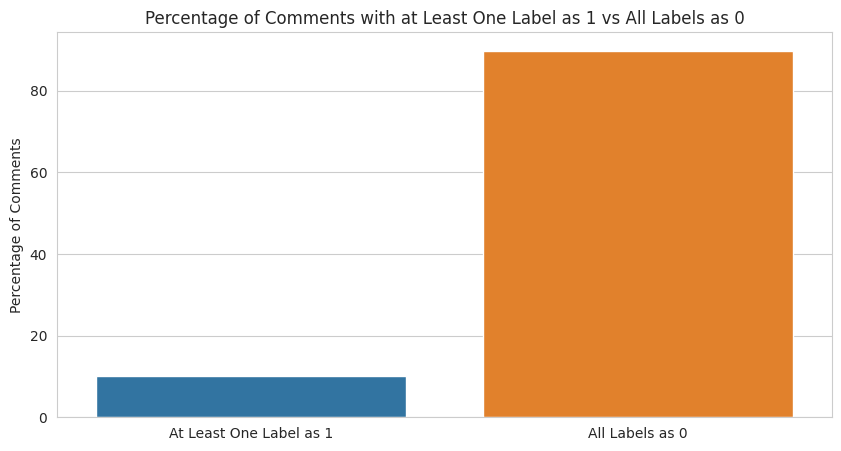

In [ ]:
at_least_one = train_data[labels].any(axis=1).sum()
all_zero = (train_data[labels].sum(axis=1) == 0).sum()

one = (at_least_one / len(train_data)) * 100
zero = (all_zero / len(train_data)) * 100

plt.figure(figsize=(10, 5))
sns.barplot(x=['At Least One Label as 1', 'All Labels as 0'], y=[one, zero])
plt.title("Percentage of Comments with at Least One Label as 1 vs All Labels as 0")
plt.ylabel("Percentage of Comments")
plt.show()

# Correlation Matrix of Labels

* Now we were sure that we would have to balance the dataset in order to get better classification results

* Since this was a multi-class classification problem, we plotted a correlation matrix to visualize how the classes were related to one another

* As can be seen in the matrix, obscene and threat correlated the most with the other classes while threat correlated the least

* But does this mean that if a comment is marked as threat, it is not toxic? Hmm... good food for thought

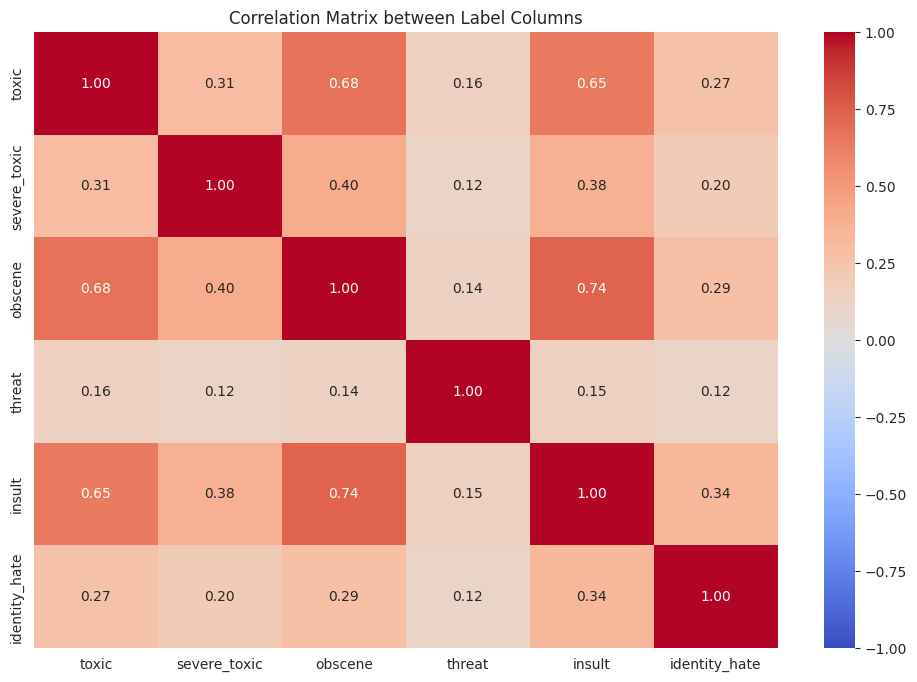

In [ ]:
correlation_matrix = train_data[label_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Matrix between Label Columns")
plt.show()

# Length of Comments

* We actually read around 100 comments, a few of which were hilarious

* The lengths greatly varied in all the comments and we thought this would be a good metric to judge the comments on

* The distribution obtained was intuitive, there was an exponential decrease in frequency of comments as the length increased

* Although very little in frequency, there were comments greater than 400 words as well! Oh well, who even had the time to write such a comment

In [ ]:
tweets = train_data['comment_text']
word_lengths = tweets.apply(lambda x: len(str(x).split()))


word_lengths_count = word_lengths.value_counts().sort_index()
word_length_percentage = word_lengths_count / len(word_lengths) * 100
print("Percentage of each word length:")
print(word_length_percentage)

Percentage of each word length:
1       0.010654
2       0.092749
3       0.447450
4       1.883174
5       2.306183
          ...   
1250    0.003760
1344    0.000627
1354    0.000627
1403    0.000627
1411    0.000627
Name: comment_text, Length: 932, dtype: float64


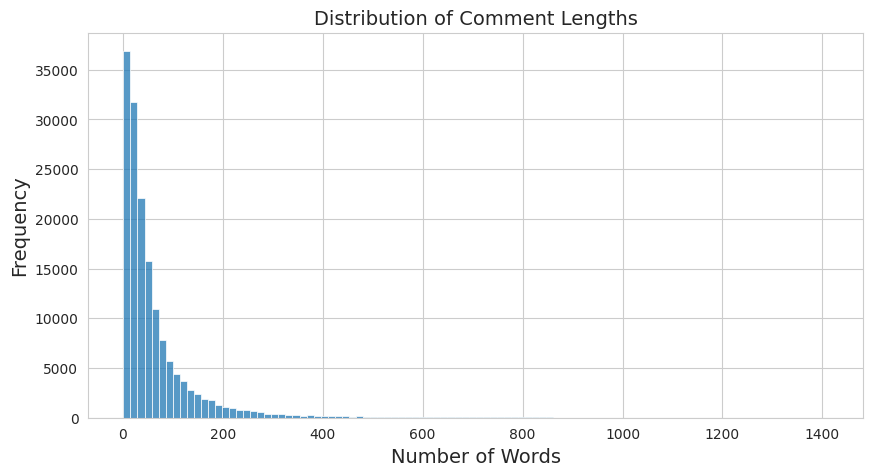

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10,5))
sns.histplot(word_lengths, bins=100);
plt.xlabel("Number of Words", fontsize=14);
plt.ylabel("Frequency", fontsize=14);
plt.title("Distribution of Comment Lengths", fontsize=14);

# WordCloud of words in Dataset

* After plotting the comment lenghts, we thought to dive a bit deeper into the comments and actually see what the most frequent words were in the dataset

* We got a couple of ideas, out of which the WordCloud was something unanimously agreed upon but we were convinced that it would be impossible to code such a thing

* To our surprise, Python had a whole library for it!

* This was one of the most satisfying visuals we made during the course of this project

* We tried to actually guess words that would occur the most frequently before plotting the wordcloud but none of us guessed article as being the most frequent word.

* Interesting observation that this dataset contains comments somehow related to articles

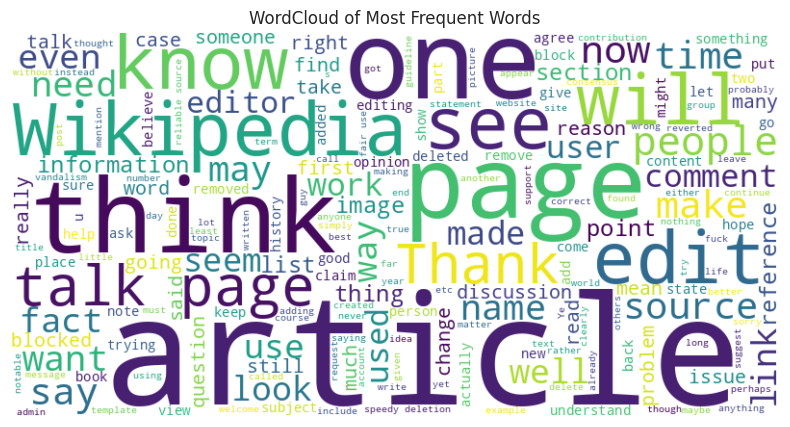

In [ ]:
text_data = " ".join(tweets)
wordcloud = WordCloud(width=800, height=400, random_state=42, max_words=200, background_color='white').generate(text_data)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of Most Frequent Words')
plt.show()

# Conditional Probabilities for Labels

* Since discussing the Naive Bayes Classifier lead to the discussion of Bayes Theorem and probabilities, we thought that calculating and plotting the conditional probabilities of each pair of labels would be a good idea to gain some insights.

* It was interesting to see how one class had a very high probability of occuring given the other class but the converse wasn't really true

* This was a testament to the fact that the class was heavily imbalanced and further solidified our earlier realizations

In [ ]:
conditional_probabilities = {}

for label1 in label_columns:
    for label2 in label_columns:
        if label1 != label2:
            # P(A) - Probability that a tweet has label1
            prob_label1 = train_data[label1].sum() / len(train_data)

            # P(B) - Probability that a tweet has label2
            prob_label2 = train_data[label2].sum() / len(train_data)

            # P(A|B) - Probability that a tweet has label1 given that it has label2
            prob_label1_given_label2 = train_data[train_data[label2] == 1][label1].sum() / train_data[label2].sum()

            # P(B|A) - Probability that a tweet has label2 given that it has label1
            prob_label2_given_label1 = (prob_label1_given_label2 * prob_label2) / prob_label1

            conditional_probabilities[f'P({label1}|{label2})'] = prob_label1_given_label2
            conditional_probabilities[f'P({label2}|{label1})'] = prob_label2_given_label1

        else:
            conditional_probabilities[f'P({label1}|{label2})'] = 1

for key, value in conditional_probabilities.items():
    print(f"{key}: {value:.4f}")

P(toxic|toxic): 1.0000
P(toxic|severe_toxic): 1.0000
P(severe_toxic|toxic): 0.1043
P(toxic|obscene): 0.9381
P(obscene|toxic): 0.5182
P(toxic|threat): 0.9393
P(threat|toxic): 0.0294
P(toxic|insult): 0.9323
P(insult|toxic): 0.4802
P(toxic|identity_hate): 0.9267
P(identity_hate|toxic): 0.0851
P(severe_toxic|severe_toxic): 1.0000
P(severe_toxic|obscene): 0.1795
P(obscene|severe_toxic): 0.9511
P(severe_toxic|threat): 0.2343
P(threat|severe_toxic): 0.0702
P(severe_toxic|insult): 0.1741
P(insult|severe_toxic): 0.8596
P(severe_toxic|identity_hate): 0.2228
P(identity_hate|severe_toxic): 0.1962
P(obscene|obscene): 1.0000
P(obscene|threat): 0.6297
P(threat|obscene): 0.0356
P(obscene|insult): 0.7814
P(insult|obscene): 0.7285
P(obscene|identity_hate): 0.7345
P(identity_hate|obscene): 0.1221
P(threat|threat): 1.0000
P(threat|insult): 0.0390
P(insult|threat): 0.6423
P(threat|identity_hate): 0.0698
P(identity_hate|threat): 0.2050
P(insult|insult): 1.0000
P(insult|identity_hate): 0.8256
P(identity_hate

Text(0.5, 1.0, 'Conditional Probabilities Heatmap')

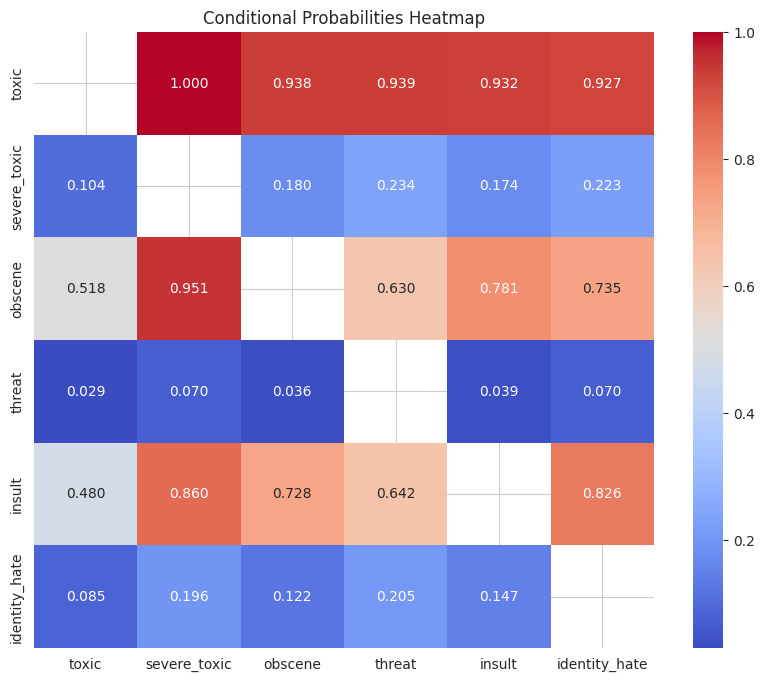

In [ ]:
cond_prob = pd.DataFrame(index=label_columns, columns=label_columns)

for label1 in label_columns:
    for label2 in label_columns:
        if label1 != label2:
            prob_label1 = train_data[label1].sum() / len(train_data)
            prob_label2 = train_data[label2].sum() / len(train_data)

            prob_label1_given_label2 = train_data[train_data[label2] == 1][label1].sum() / train_data[label2].sum()
            prob_label2_given_label1 = (prob_label1_given_label2 * prob_label2) / prob_label1

            cond_prob.loc[label1, label2] = prob_label1_given_label2
            cond_prob.loc[label2, label1] = prob_label2_given_label1

cond_prob = cond_prob.apply(pd.to_numeric)

plt.figure(figsize=(10, 8))
sns.heatmap(cond_prob, annot=True, cmap='coolwarm', fmt=".3f")
plt.title('Conditional Probabilities Heatmap')
